In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

import statsmodels.api as sm

pd.set_option('display.max_rows', 500)


In [2]:
df = pd.read_csv('data_forecast.csv')

In [3]:
df['MONTH'] = df['MONTH'].astype('category')
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype('category')
df['OP_UNIQUE_CARRIER'] = df['OP_UNIQUE_CARRIER'].astype('category')
df['TAIL_NUM'] = df['TAIL_NUM'].astype('category')
df['OP_CARRIER_FL_NUM'] = df['OP_CARRIER_FL_NUM'].astype('category')
df['ORIGIN'] = df['ORIGIN'].astype('category')
df['DEST'] = df['DEST'].astype('category')
df['DELAY_CAT'] = df['DELAY_CAT'].astype('category')
df['DELAYED'] = df['DELAYED'].astype(np.int8)
df['CRS_DEP_TIME_CAT'] = df['CRS_DEP_TIME_CAT'].astype('category')
df['CRS_ARR_TIME_CAT'] = df['CRS_ARR_TIME_CAT'].astype('category')
df['PAUSE_CAT'] = df['PAUSE_CAT'].astype('category')
df['ROLLING_DELAYED'] = df['ROLLING_DELAYED'].astype('category')
df['DAY_OF_MONTH'] = df['DAY_OF_MONTH'].astype(np.int8)
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].astype(np.int16)
df['DEP_DELAY'] = df['DEP_DELAY'].astype(np.float16)
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].astype(np.int16)
df['ARR_DELAY'] = df['ARR_DELAY'].astype(np.float16)
df['DISTANCE'] = df['DISTANCE'].astype(np.int16)
df['NUM_OF_DEP'] = df['NUM_OF_DEP'].astype(np.int8)
df['NUM_OF_ARR'] = df['NUM_OF_ARR'].astype(np.int8)
df['PREVIOUS_ARR'] = df['PREVIOUS_ARR'].astype(np.float64)
df['PAUSE_TIME'] =df['PAUSE_TIME'].astype(np.float64)
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format="%Y/%m/%d")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990099 entries, 0 to 4990098
Data columns (total 25 columns):
Unnamed: 0           int64
MONTH                category
DAY_OF_MONTH         int8
DAY_OF_WEEK          category
FL_DATE              datetime64[ns]
OP_UNIQUE_CARRIER    category
TAIL_NUM             category
OP_CARRIER_FL_NUM    category
ORIGIN               category
DEST                 category
CRS_DEP_TIME         int16
DEP_DELAY            float16
CRS_ARR_TIME         int16
ARR_DELAY            float16
DISTANCE             int16
DELAY_CAT            category
DELAYED              int8
CRS_DEP_TIME_CAT     category
CRS_ARR_TIME_CAT     category
NUM_OF_DEP           int8
NUM_OF_ARR           int8
PREVIOUS_ARR         float64
PAUSE_TIME           float64
PAUSE_CAT            category
ROLLING_DELAYED      category
dtypes: category(12), datetime64[ns](1), float16(2), float64(2), int16(3), int64(1), int8(4)
memory usage: 295.6 MB


In [5]:
df.isnull().sum()

Unnamed: 0                 0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
FL_DATE                    0
OP_UNIQUE_CARRIER          0
TAIL_NUM                   0
OP_CARRIER_FL_NUM          0
ORIGIN                     0
DEST                       0
CRS_DEP_TIME               0
DEP_DELAY                  0
CRS_ARR_TIME               0
ARR_DELAY                  0
DISTANCE                   0
DELAY_CAT                  0
DELAYED                    0
CRS_DEP_TIME_CAT           0
CRS_ARR_TIME_CAT           0
NUM_OF_DEP                 0
NUM_OF_ARR                 0
PREVIOUS_ARR         1232018
PAUSE_TIME           1232018
PAUSE_CAT                  0
ROLLING_DELAYED            0
dtype: int64

## WEEKS 

In [6]:
train1new = df[(df['MONTH'].isin(['Styczen', 'Luty'])) | ((df['MONTH'] == 'Marzec') & (df['DAY_OF_MONTH'].isin(np.arange(1,13))))]
test1new = df[(df['MONTH'] == 'Marzec') & (df['DAY_OF_MONTH'].isin(np.arange(13,32)))]
train2new = df[(df['MONTH'].isin(['Kwiecien', 'Maj'])) | ((df['MONTH'] == 'Czerwiec') & (df['DAY_OF_MONTH'].isin(np.arange(1,12))))]
test2new = df[(df['MONTH'] == 'Czerwiec') & (df['DAY_OF_MONTH'].isin(np.arange(12,31)))]
train3new = df[(df['MONTH'].isin(['Lipiec', 'Sierpien'])) | ((df['MONTH'] == 'Wrzesien') & (df['DAY_OF_MONTH'].isin(np.arange(1,11))))]
test3new = df[(df['MONTH'] == 'Wrzesien') & (df['DAY_OF_MONTH'].isin(np.arange(11,31)))]
train4new = df[(df['MONTH'].isin(['Pazdziernik', 'Listopad'])) | ((df['MONTH'] == 'Grudzien') & (df['DAY_OF_MONTH'].isin(np.arange(1,11))))]
test4new = df[(df['MONTH'] == 'Grudzien') & (df['DAY_OF_MONTH'].isin(np.arange(11,32)))]

In [7]:
columns_to_use = ['DAY_OF_WEEK', 'ORIGIN', 'OP_UNIQUE_CARRIER', 'DISTANCE',
                  'CRS_DEP_TIME_CAT', 'NUM_OF_DEP', 'NUM_OF_ARR',
#                   'PAUSE_CAT',
                  'ROLLING_DELAYED', 'DELAYED']
def train_test(sample_train, sample_test, get_dummies=None, scale=None):
    train = sample_train[columns_to_use]
    train = train.reset_index(drop=True)
    test = sample_test[columns_to_use]
    test = test.reset_index(drop=True)
    ###
    omean = train.groupby(['OP_UNIQUE_CARRIER'])['DELAYED'].mean()
    gmean = train.groupby(['ORIGIN'])['DELAYED'].mean()
    cmean = train.groupby(['CRS_DEP_TIME_CAT'])['DELAYED'].mean()
    #tmean = train.groupby(['TAIL_NUM'])['DELAYED'].mean()
    train.loc[:,'MEAN_ORIGIN'] = train['ORIGIN'].map(gmean)
    test.loc[:,'MEAN_ORIGIN'] = test['ORIGIN'].map(gmean)
    train.loc[:,'MEAN_DEP'] = train['CRS_DEP_TIME_CAT'].map(cmean)
    test.loc[:,'MEAN_DEP'] = test['CRS_DEP_TIME_CAT'].map(cmean)
    train.loc[:,'MEAN_OP'] = train['OP_UNIQUE_CARRIER'].map(omean)
    test.loc[:,'MEAN_OP'] = test['OP_UNIQUE_CARRIER'].map(omean)
    #train.loc[:,'MEAN_TN'] = train['TAIL_NUM'].map(tmean)
    #test.loc[:,'MEAN_TN'] = test['TAIL_NUM'].map(tmean)
    ###
    train.dropna(inplace=True)
    test.dropna(inplace=True)
    y_train = train['DELAYED']
    y_test = test['DELAYED']
    train.drop(columns=['ORIGIN', 'DELAYED', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME_CAT'], axis=1, inplace=True)
    test.drop(columns=['ORIGIN', 'DELAYED', 'OP_UNIQUE_CARRIER', 'CRS_DEP_TIME_CAT'], axis=1, inplace=True)
    if get_dummies:
        train = pd.get_dummies(data = train, drop_first=True)
        test = pd.get_dummies(data = test, drop_first=True)
    if scale:
        sc = StandardScaler()
        train = sc.fit_transform(train)
        test = sc.fit_transform(test)
        

    print('Liczba obserwacji treningowych:', train.shape[0])
    print('Liczba obserwacji testowych:', test.shape[0])
    print('Liczba kolumn:', train.shape[1])
    print('Rozkład zmiennej endogenicznej:\n')
    print(y_train.value_counts(normalize=True))
    
    return train, test, y_train, y_test

In [8]:
def model_perfomance(model, x_train, y_train, x_test, y_test, ols=None, coef=None, importance=None):
    model.fit(x_train, y_train)
    Y_PRED = model.predict(x_test)
    Y_PRED_PROBA = model.predict_proba(x_test)

    
    #Y_PRED_PROBA_CUT = (Y_PRED_PROBA[:,1] > 0.27).astype(int)
    cnf = confusion_matrix(y_test,Y_PRED).T
    cnf = pd.DataFrame(cnf)
    acc = accuracy_score(y_test, Y_PRED)
    rec = recall_score(y_test, Y_PRED)
    prec = precision_score(y_test, Y_PRED)
    f1 = f1_score(y_test, Y_PRED)
    auc = roc_auc_score(y_test, Y_PRED_PROBA[:,1])
    f, t, th = roc_curve(y_test, Y_PRED_PROBA[:,1])
    p, r, thresholds = precision_recall_curve(y_test, Y_PRED_PROBA[:,1])

    print('Accuracy: ', round(accuracy_score(y_test, Y_PRED), 4))
    print('Recall: ', round(recall_score(y_test, Y_PRED), 4))
    print('Precision: ', round(precision_score(y_test, Y_PRED), 4))
    print('F1 Score: ', round(f1_score(y_test, Y_PRED), 4))
    print('ROC AUC Score:', round(auc, 4))
    bar = pd.DataFrame(index=['Measure', 'Value'],
                      data=[['Accuracy', 'Recall', 'Precision'],[acc,rec,prec]])
    bar = bar.T
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2, 2)
    plt.subplot(gs[0,:1])
    sns.heatmap(cnf, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.subplot(gs[0,1:])
    sns.barplot(y=bar['Measure'], x=bar['Value'], edgecolor='black')
    if coef:
        coef = pd.DataFrame(columns=x_train.columns, data=model.coef_)
        print(model.coef_.shape)
        plt.subplot(gs[1,:])
        sns.barplot(x=coef.T.index, y=coef.T[0])
        plt.xticks(rotation=90)
    if importance:
        coef = pd.DataFrame(columns=X_TRAIN.columns, data=np.transpose(model.feature_importances_))
        print(np.transpose(model.feature_importances_).shape)
        plt.subplot(313)
        sns.barplot(x=x_train.columns,y=model.feature_importances_)
        plt.xticks(rotation=90)
    return model, acc, rec, prec, auc, f1, f, t, th, p, r, thresholds, Y_PRED_PROBA, coef

In [9]:
def model_perfomance_ols(model, x_train, y_train, x_test, y_test, coef=None, importance=None):
    model.fit(x_train, y_train)
    Y_PRED_PROBA = ols.predict(x_test)
    Y_PRED = np.where(Y_PRED_PROBA > 0.50, 1, 0)
    
    #Y_PRED_PROBA_CUT = (Y_PRED_PROBA[:,1] > 0.27).astype(int)
    cnf = confusion_matrix(y_test,Y_PRED).T
    cnf = pd.DataFrame(cnf)
    acc = accuracy_score(y_test, Y_PRED)
    rec = recall_score(y_test, Y_PRED)
    prec = precision_score(y_test, Y_PRED)
    f1 = f1_score(y_test, Y_PRED)
    auc = roc_auc_score(y_test, Y_PRED_PROBA)
    f, t, th = roc_curve(y_test, Y_PRED_PROBA)
    p, r, thresholds = precision_recall_curve(y_test, Y_PRED_PROBA)

    print('Accuracy: ', round(accuracy_score(y_test, Y_PRED), 4))
    print('Recall: ', round(recall_score(y_test, Y_PRED), 4))
    print('Precision: ', round(precision_score(y_test, Y_PRED), 4))
    print('F1 Score: ', round(f1_score(y_test, Y_PRED), 4))
    print('ROC AUC Score:', round(auc, 4))
    bar = pd.DataFrame(index=['Measure', 'Value'],
                      data=[['Accuracy', 'Recall', 'Precision'],[acc,rec,prec]])
    bar = bar.T
    plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2, 2)
    plt.subplot(gs[0,:1])
    sns.heatmap(cnf, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.subplot(gs[0,1:])
    sns.barplot(y=bar['Measure'], x=bar['Value'], edgecolor='black')
    if coef:
        coef = pd.DataFrame(columns=x_train.columns, data=model.coef_.reshape(1,-1))
        print(model.coef_.shape)
        plt.subplot(gs[1,:])
        sns.barplot(x=coef.T.index, y=coef.T[0])
        plt.xticks(rotation=90)
    if importance:
        coef = pd.DataFrame(columns=X_TRAIN.columns, data=np.transpose(model.feature_importances_))
        print(np.transpose(model.feature_importances_).shape)
        plt.subplot(313)
        sns.barplot(x=x_train.columns,y=model.feature_importances_)
        plt.xticks(rotation=90)
    return model, acc, rec, prec, auc, f1, f, t, th, p, r, thresholds, Y_PRED_PROBA, coef

# # MODELS

In [10]:
logit = LogisticRegression(C=0.005, penalty='l2', max_iter=500, solver='lbfgs', random_state=77)
ols =LinearRegression()
nb = GaussianNB()

# # ESTIMATION

In [11]:
x_train, x_test, y_train, y_test = train_test(train1new, test1new, get_dummies=True, scale=False)

Liczba obserwacji treningowych: 858605
Liczba obserwacji testowych: 275778
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.805238
1    0.194762
Name: DELAYED, dtype: float64


In [16]:
reg_log = sm.Logit(y_train, x_train).fit_regularized(method='l1', alpha=0.005, maxiter=10000)
print(reg_log.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27789710130102885
            Iterations: 141
            Function evaluations: 152
            Gradient evaluations: 141


C:\Users\drynkiewicz\conda\lib\site-packages\statsmodels\base\l1_solvers_common.py:73: ConvergenceWarning: QC check did not pass for 20 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
C:\Users\drynkiewicz\conda\lib\site-packages\statsmodels\base\l1_solvers_common.py:146: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                DELAYED   No. Observations:               858605
Model:                          Logit   Df Residuals:                   858585
Method:                           MLE   Df Model:                           19
Date:                Tue, 08 Oct 2019   Pseudo R-squ.:                  0.4364
Time:                        09:56:06   Log-Likelihood:            -2.3860e+05
converged:                       True   LL-Null:                   -4.2334e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                  3.113e-06   5.85e-06      0.532      0.595   -8.36e-06    1.46e-05
NUM_OF_DEP                  -0.0102      0.000    -49.968      0.000      -0.011      -0.

In [13]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())
model = sm.Logit(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DELAYED   R-squared:                   -1400.983
Model:                            OLS   Adj. R-squared:              -1401.016
Method:                 Least Squares   F-statistic:                -4.290e+04
Date:                Wed, 25 Sep 2019   Prob (F-statistic):               1.00
Time:                        18:24:28   Log-Likelihood:            -1.9139e+05
No. Observations:              858605   AIC:                         3.828e+05
Df Residuals:                  858585   BIC:                         3.830e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                

C:\Data science\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                DELAYED   No. Observations:               858605
Model:                          Logit   Df Residuals:                   858585
Method:                           MLE   Df Model:                           19
Date:                Wed, 25 Sep 2019   Pseudo R-squ.:                  0.4364
Time:                        18:24:43   Log-Likelihood:            -2.3860e+05
converged:                      False   LL-Null:                   -4.2334e+05
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                  3.097e-06   5.85e-06      0.529      0.597   -8.38e-06    1.46e-05
NUM_OF_DEP                  -0.0102      0.000    -49.968      0.000      -0.011      -0.

In [14]:
x_train, x_test, y_train, y_test = train_test(train2new, test2new, get_dummies=True, scale=False)

Liczba obserwacji treningowych: 1000573
Liczba obserwacji testowych: 291837
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.78026
1    0.21974
Name: DELAYED, dtype: float64


In [15]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())
model = sm.Logit(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DELAYED   R-squared:                    2512.541
Model:                            OLS   Adj. R-squared:               2512.591
Method:                 Least Squares   F-statistic:                -5.005e+04
Date:                Wed, 25 Sep 2019   Prob (F-statistic):               1.00
Time:                        18:24:49   Log-Likelihood:            -2.4416e+05
No. Observations:             1000573   AIC:                         4.884e+05
Df Residuals:                 1000553   BIC:                         4.886e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                

C:\Data science\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                DELAYED   No. Observations:              1000573
Model:                          Logit   Df Residuals:                  1000553
Method:                           MLE   Df Model:                           19
Date:                Wed, 25 Sep 2019   Pseudo R-squ.:                  0.4404
Time:                        18:25:05   Log-Likelihood:            -2.9486e+05
converged:                      False   LL-Null:                   -5.2688e+05
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                  -1.96e-05   5.27e-06     -3.720      0.000   -2.99e-05   -9.27e-06
NUM_OF_DEP                  -0.0090      0.000    -49.174      0.000      -0.009      -0.

In [16]:
x_train, x_test, y_train, y_test = train_test(train3new, test3new, get_dummies=True, scale=False)

Liczba obserwacji treningowych: 1036178
Liczba obserwacji testowych: 292976
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.765763
1    0.234237
Name: DELAYED, dtype: float64


In [17]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())
model = sm.Logit(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DELAYED   R-squared:                   -4493.510
Model:                            OLS   Adj. R-squared:              -4493.597
Method:                 Least Squares   F-statistic:                -5.180e+04
Date:                Wed, 25 Sep 2019   Prob (F-statistic):               1.00
Time:                        18:25:11   Log-Likelihood:            -2.7611e+05
No. Observations:             1036178   AIC:                         5.523e+05
Df Residuals:                 1036158   BIC:                         5.525e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                

C:\Data science\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                DELAYED   No. Observations:              1036178
Model:                          Logit   Df Residuals:                  1036158
Method:                           MLE   Df Model:                           19
Date:                Wed, 25 Sep 2019   Pseudo R-squ.:                  0.4342
Time:                        18:25:28   Log-Likelihood:            -3.1915e+05
converged:                      False   LL-Null:                   -5.6404e+05
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                 -8.071e-05   4.96e-06    -16.255      0.000   -9.04e-05    -7.1e-05
NUM_OF_DEP                  -0.0106      0.000    -61.091      0.000      -0.011      -0.

In [18]:
x_train, x_test, y_train, y_test = train_test(train4new, test4new, get_dummies=True, scale=False)

Liczba obserwacji treningowych: 947697
Liczba obserwacji testowych: 286368
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.849825
1    0.150175
Name: DELAYED, dtype: float64


In [19]:
model = sm.OLS(y_train, x_train).fit()
print(model.summary())
model = sm.Logit(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                DELAYED   R-squared:                    4562.747
Model:                            OLS   Adj. R-squared:               4562.843
Method:                 Least Squares   F-statistic:                -4.739e+04
Date:                Wed, 25 Sep 2019   Prob (F-statistic):               1.00
Time:                        18:25:34   Log-Likelihood:            -1.2990e+05
No. Observations:              947697   AIC:                         2.598e+05
Df Residuals:                  947677   BIC:                         2.601e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                

C:\Data science\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                DELAYED   No. Observations:               947697
Model:                          Logit   Df Residuals:                   947677
Method:                           MLE   Df Model:                           19
Date:                Wed, 25 Sep 2019   Pseudo R-squ.:                  0.4434
Time:                        18:25:50   Log-Likelihood:            -2.2313e+05
converged:                      False   LL-Null:                   -4.0089e+05
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
DISTANCE                  -5.67e-05   6.02e-06     -9.421      0.000   -6.85e-05   -4.49e-05
NUM_OF_DEP                  -0.0121      0.000    -56.132      0.000      -0.013      -0.

# LOGIT

Liczba obserwacji treningowych: 858605
Liczba obserwacji testowych: 275778
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.805238
1    0.194762
Name: DELAYED, dtype: float64
Accuracy:  0.8577
Recall:  0.4743
Precision:  0.7045
F1 Score:  0.5669
ROC AUC Score: 0.9056
(1, 20)
Liczba obserwacji treningowych: 1000573
Liczba obserwacji testowych: 291837
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.78026
1    0.21974
Name: DELAYED, dtype: float64
Accuracy:  0.8409
Recall:  0.5919
Precision:  0.7521
F1 Score:  0.6625
ROC AUC Score: 0.9012
(1, 20)
Liczba obserwacji treningowych: 1036178
Liczba obserwacji testowych: 292976
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.765763
1    0.234237
Name: DELAYED, dtype: float64
Accuracy:  0.8866
Recall:  0.4021
Precision:  0.6942
F1 Score:  0.5092
ROC AUC Score: 0.9187
(1, 20)
Liczba obserwacji treningowych: 947697
Liczba obserwacji testowych: 286368
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.849825
1    

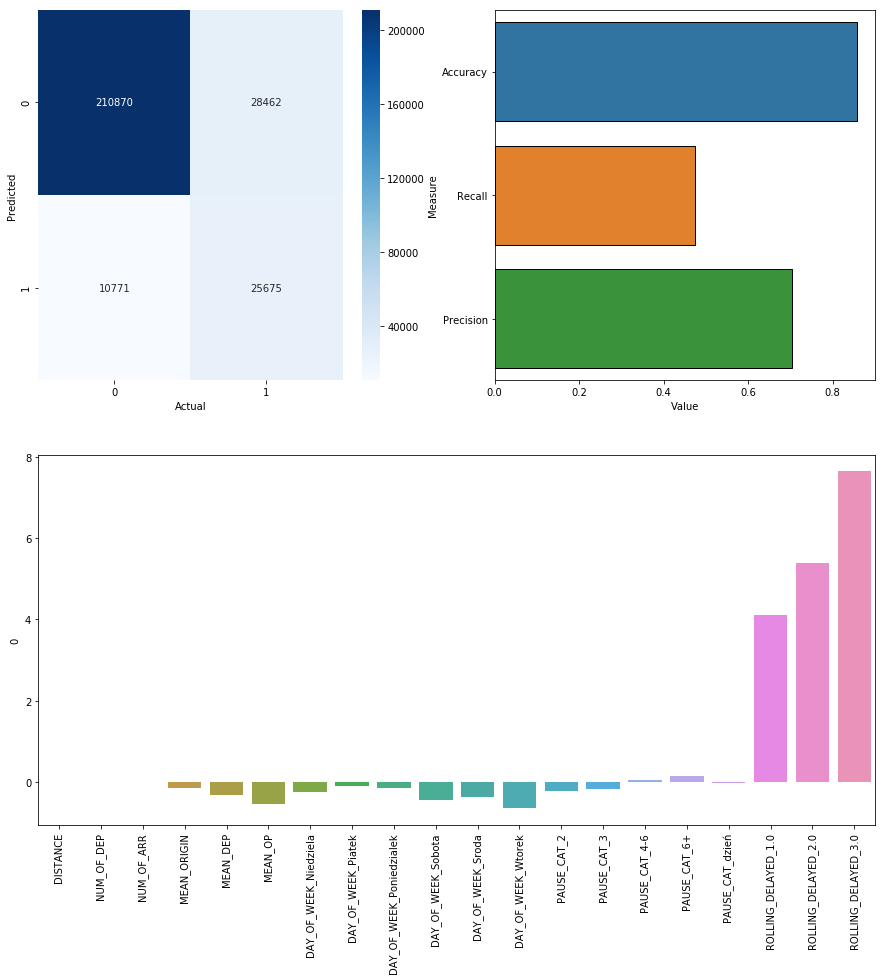

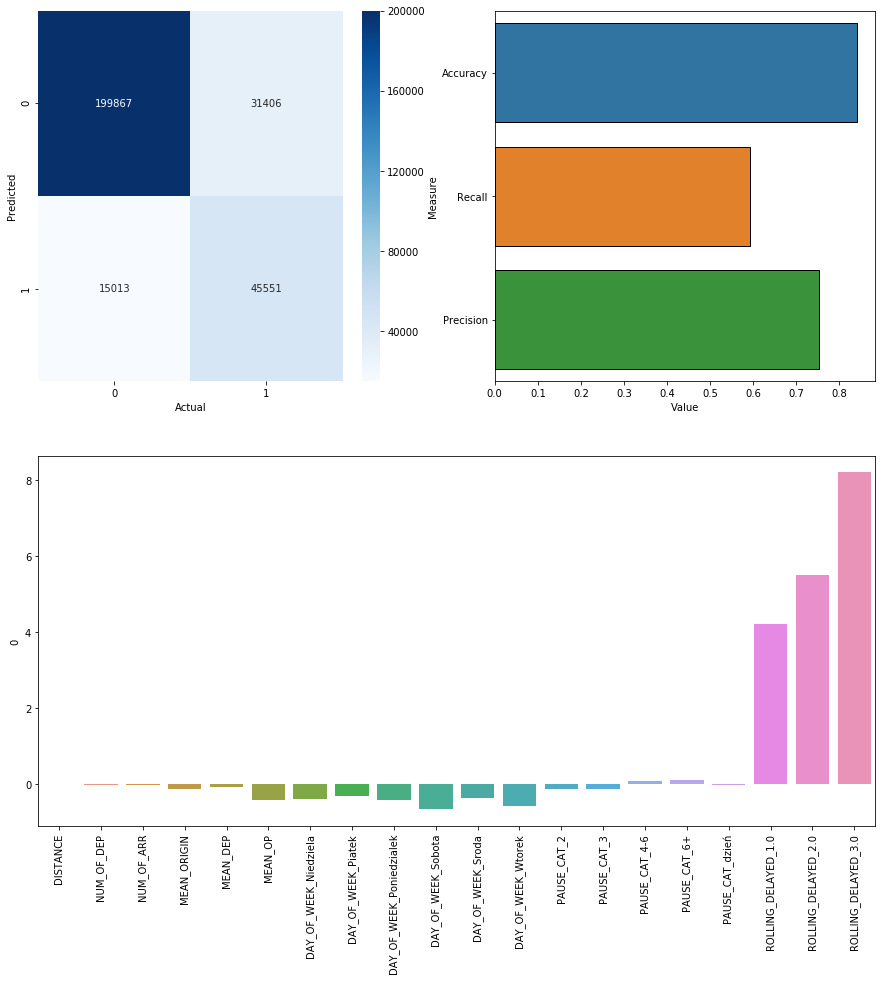

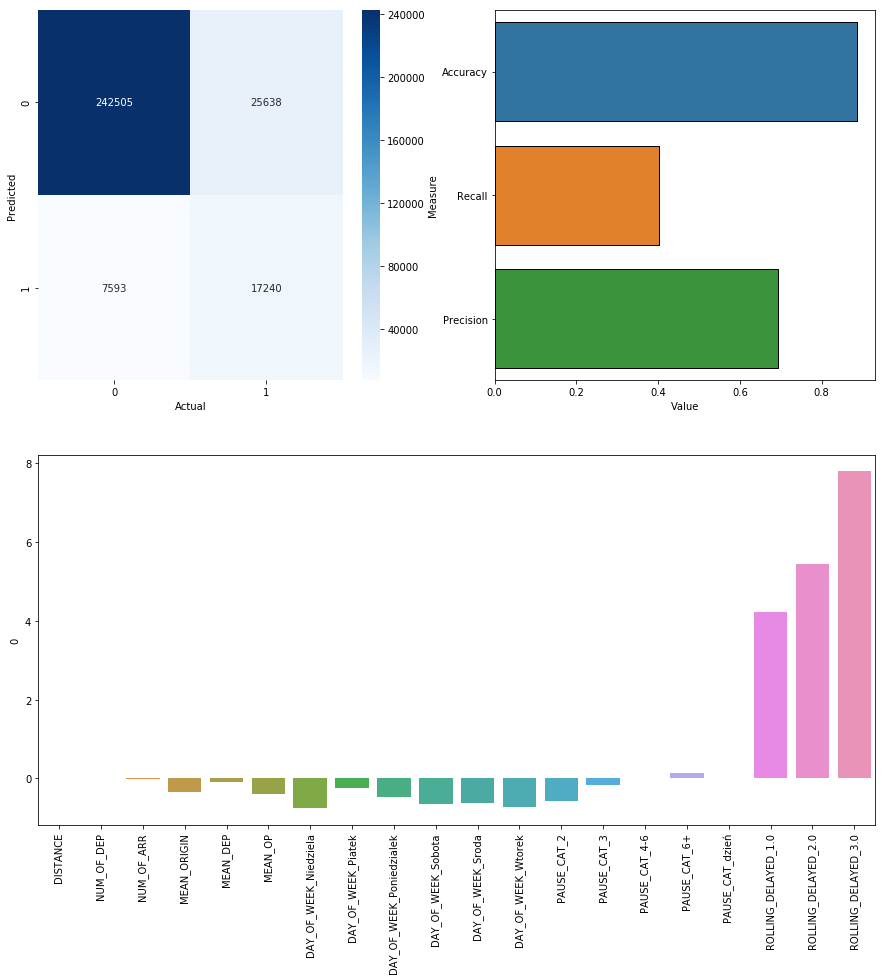

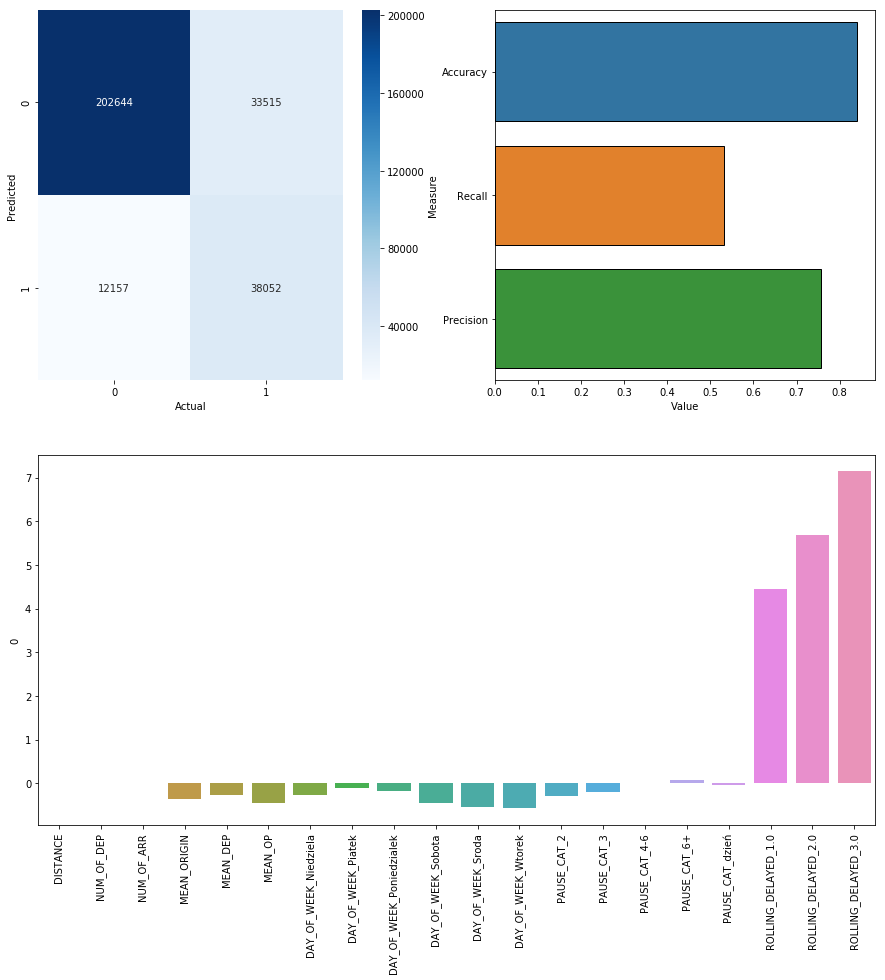

In [20]:
#nowe
group_train = [train1new,train2new,train3new,train4new]
group_test = [test1new,test2new,test3new,test4new]
index = [0,1,2,3]
scores = pd.DataFrame(columns=['Acc', 'Recall', 'Precision', 'F1', 'AUC'], index=index, dtype=np.float)
data_score = pd.DataFrame(columns=['miara', 'score', 'cut_off'])
data_coef = pd.DataFrame()
data_histogram = pd.DataFrame(columns=[1, 2, 3, 4])
fpr = []
tpr = []
thresh = []
pr = []
re = []
threshhh = []

columns_to_use = ['DAY_OF_WEEK', 'ORIGIN', 'OP_UNIQUE_CARRIER', 'DISTANCE',
                  'CRS_DEP_TIME_CAT', 'NUM_OF_DEP', 'NUM_OF_ARR', 'PAUSE_CAT',
                  'ROLLING_DELAYED', 'DELAYED']


for i, (train, test) in zip(index, zip(group_train, group_test)):
    x_train, x_test, y_train, y_test = train_test(train, test, get_dummies=True, scale=False)
    model, acc, rec, prec, auc, f1, f, t, th, p, r, thresholds, probality, coef = model_perfomance(logit, x_train, y_train, x_test, y_test, coef=True)
    scores.loc[i]['Acc'] = acc
    scores.loc[i]['Recall'] = rec
    scores.loc[i]['Precision'] = prec
    scores.loc[i]['F1'] = f1
    scores.loc[i]['AUC'] = auc
    data_histogram.iloc[:,i] = pd.Series(probality[:,1])
    data_concat = pd.DataFrame({'miara': ['Acc', 'Recall', 'Precision', 'F1', 'AUC'],
                              'score': [acc, rec, prec, f1, auc],
                              'cut_off': i})
    data_score = pd.concat([data_score, data_concat], ignore_index=True)
    #data_c = pd.DataFrame({'coef': [x for x in x_train.columns.values],
                           #'score': coef.T.values,
                           #'grupa': i})
    data_c = coef.T.reset_index()
    data_coef = pd.concat([data_coef, data_c], ignore_index=True)

    fpr.append(f)
    tpr.append(t)
    thresh.append(th)
    pr.append(p)
    re.append(r)
    threshhh.append(thresholds)

In [21]:
data_score

,miara,score,cut_off
0,Acc,0.857737,0
1,Recall,0.474260,0
2,Precision,0.704467,0
3,F1,0.566883,0
4,AUC,0.905596,0
5,Acc,0.840942,1
6,Recall,0.591902,1
7,Precision,0.752113,1
8,F1,0.662459,1
9,AUC,0.901199,1


In [12]:
data_coef['ods']= np.exp(data_coef[0])
data_coef.to_excel('logit.xlsx')

C:\Data science\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


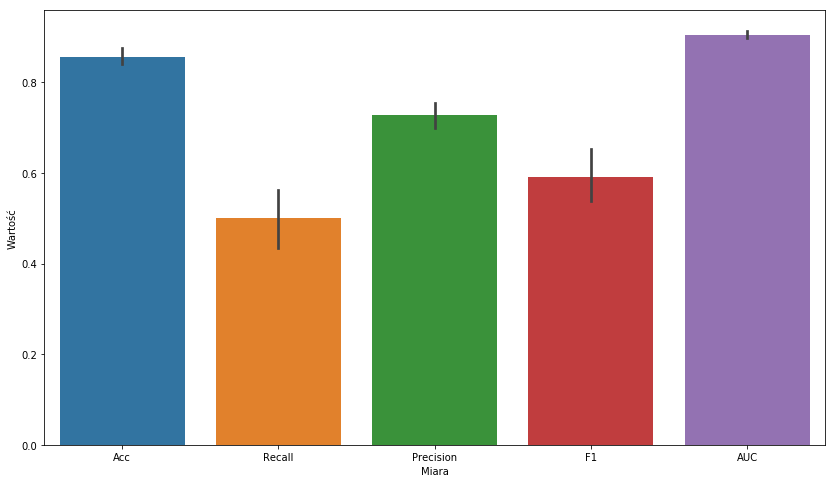

In [22]:
plt.figure(figsize=(14,8))
sns.barplot(x='miara', y='score', data=data_score)
plt.xlabel('Miara')
plt.ylabel('Wartość')
plt.show()

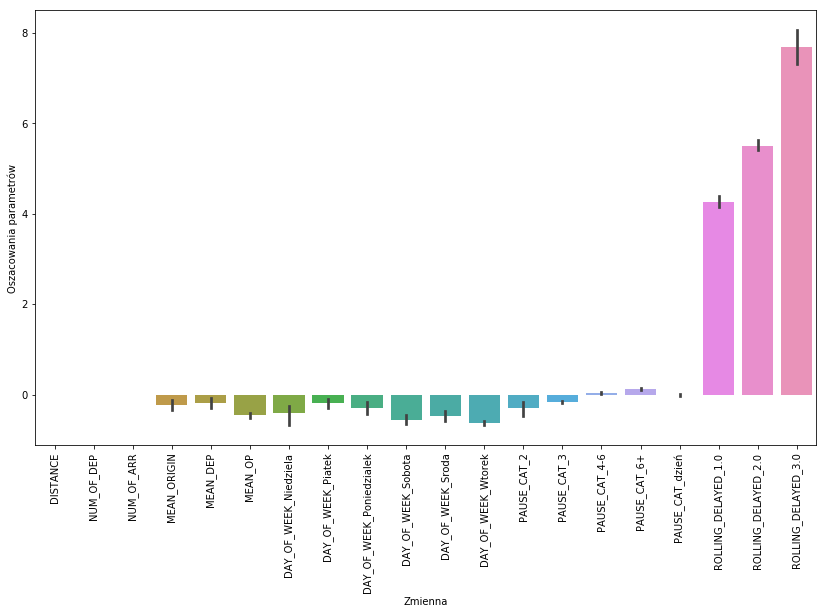

In [23]:
plt.figure(figsize=(14,8))
sns.barplot(x='index', y=0, data=data_coef)
plt.xticks(rotation=90)
plt.xlabel('Zmienna')
plt.ylabel('Oszacowania parametrów')
plt.show()

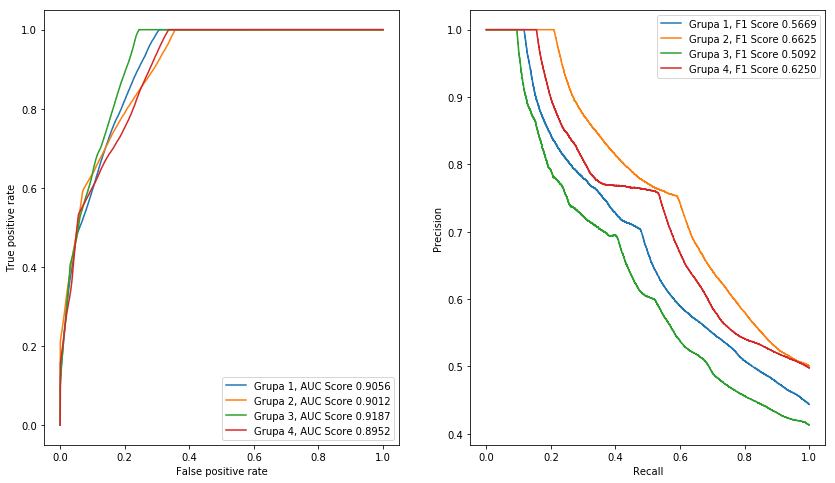

In [24]:
# 24 kolumny bez skalowania
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))
#sns.set_style('whitegrid')
ax1.plot(fpr[0], tpr[0], label='Grupa 1, AUC Score {}'.format("%.4f" % scores['AUC'][0]))
ax1.plot(fpr[1], tpr[1], label='Grupa 2, AUC Score {}'.format("%.4f" % scores['AUC'][1]))
ax1.plot(fpr[2], tpr[2], label='Grupa 3, AUC Score {}'.format("%.4f" % scores['AUC'][2]))
ax1.plot(fpr[3], tpr[3], label='Grupa 4, AUC Score {}'.format("%.4f" % scores['AUC'][3]))
ax1.set_ylabel('True positive rate')
ax1.set_xlabel('False positive rate')
ax1.legend()
ax2.plot(re[0], pr[0], label='Grupa 1, F1 Score {}'.format("%.4f" % scores['F1'][0]))
ax2.plot(re[1], pr[1], label='Grupa 2, F1 Score {}'.format("%.4f" % scores['F1'][1]))
ax2.plot(re[2], pr[2], label='Grupa 3, F1 Score {}'.format("%.4f" % scores['F1'][2]))
ax2.plot(re[3], pr[3], label='Grupa 4, F1 Score {}'.format("%.4f" % scores['F1'][3]))
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
ax2.legend()

# NB

Liczba obserwacji treningowych: 858605
Liczba obserwacji testowych: 275778
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.805238
1    0.194762
Name: DELAYED, dtype: float64
Accuracy:  0.843
Recall:  0.4898
Precision:  0.6286
F1 Score:  0.5506
ROC AUC Score: 0.8373
Liczba obserwacji treningowych: 1000573
Liczba obserwacji testowych: 291837
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.78026
1    0.21974
Name: DELAYED, dtype: float64
Accuracy:  0.8262
Recall:  0.5808
Precision:  0.7077
F1 Score:  0.638
ROC AUC Score: 0.8429
Liczba obserwacji treningowych: 1036178
Liczba obserwacji testowych: 292976
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.765763
1    0.234237
Name: DELAYED, dtype: float64
Accuracy:  0.8669
Recall:  0.3887
Precision:  0.5657
F1 Score:  0.4607
ROC AUC Score: 0.7972
Liczba obserwacji treningowych: 947697
Liczba obserwacji testowych: 286368
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.849825
1    0.150175
Name: DELAYED, dt

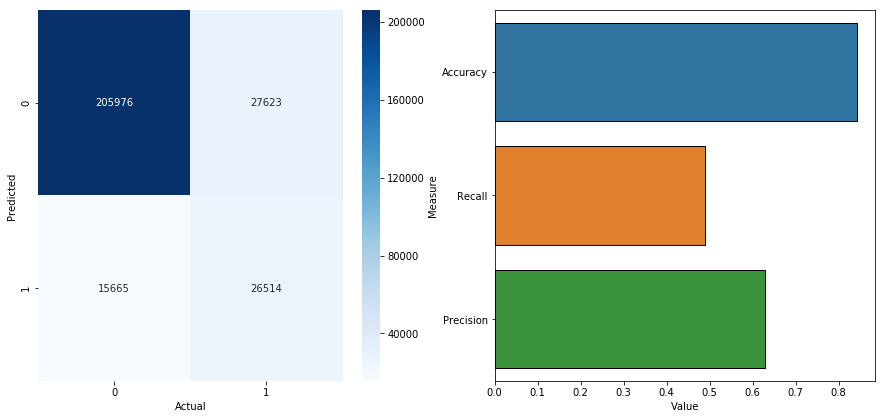

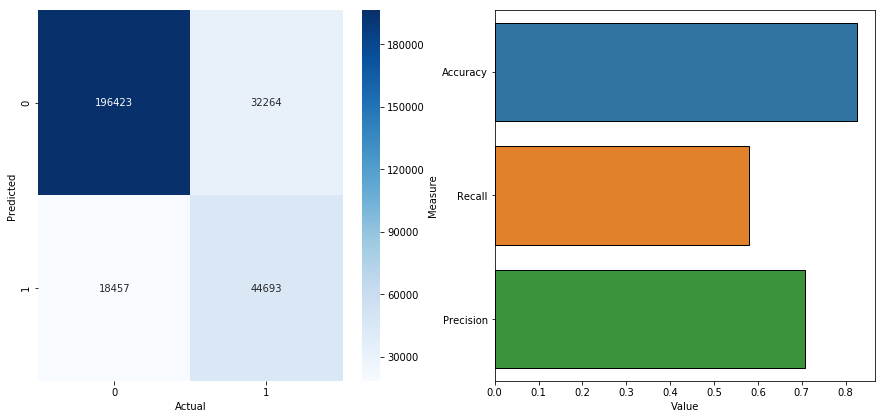

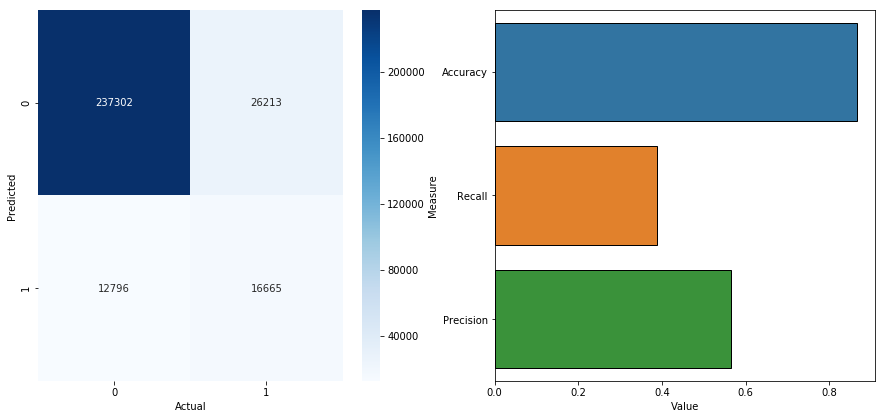

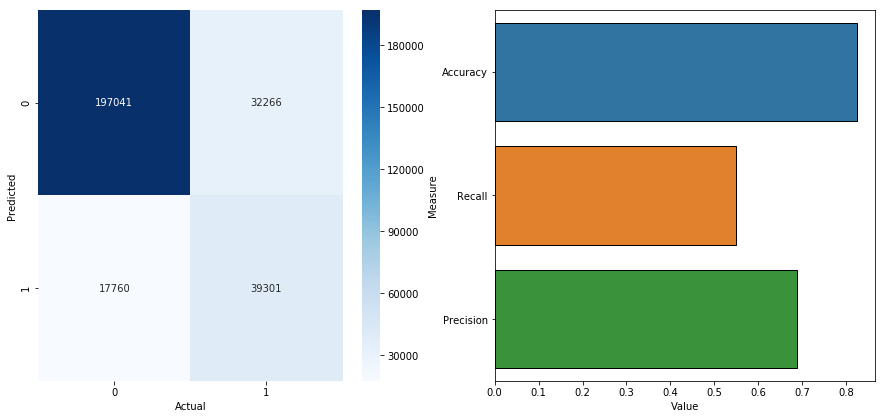

In [40]:
#nowe
group_train = [train1new,train2new,train3new,train4new]
group_test = [test1new,test2new,test3new,test4new]
index = [0,1,2,3]
scores = pd.DataFrame(columns=['Acc', 'Recall', 'Precision', 'F1', 'AUC'], index=index, dtype=np.float)
data_score = pd.DataFrame(columns=['miara', 'score', 'cut_off'])
data_coef = pd.DataFrame()
data_histogram = pd.DataFrame(columns=[1, 2, 3, 4])
fpr = []
tpr = []
thresh = []
pr = []
re = []
threshhh = []

columns_to_use = ['DAY_OF_WEEK', 'ORIGIN', 'OP_UNIQUE_CARRIER', 'DISTANCE',
                  'CRS_DEP_TIME_CAT', 'NUM_OF_DEP', 'NUM_OF_ARR', 'PAUSE_CAT',
                  'ROLLING_DELAYED', 'DELAYED']
#columns_to_use = ['ORIGIN', 'OP_UNIQUE_CARRIER', 'PAUSE_CAT', 'ROLLING_DELAYED', 'DELAYED']

for i, (train, test) in zip(index, zip(group_train, group_test)):
    x_train, x_test, y_train, y_test = train_test(train, test, get_dummies=True, scale=False)
    model, acc, rec, prec, auc, f1, f, t, th, p, r, thresholds, probality, coef = model_perfomance(nb, x_train, y_train, x_test, y_test, coef=False)
    scores.loc[i]['Acc'] = acc
    scores.loc[i]['Recall'] = rec
    scores.loc[i]['Precision'] = prec
    scores.loc[i]['F1'] = f1
    scores.loc[i]['AUC'] = auc
    data_histogram.iloc[:,i] = pd.Series(probality[:,1])
    data_concat = pd.DataFrame({'miara': ['Acc', 'Recall', 'Precision', 'F1', 'AUC'],
                              'score': [acc, rec, prec, f1, auc],
                              'cut_off': i})
    data_score = pd.concat([data_score, data_concat], ignore_index=True)
    #data_c = pd.DataFrame({'coef': [x for x in x_train.columns.values],
                           #'score': coef.T.values,
                           #'grupa': i})
    #data_c = coef.T.reset_index()
    #data_coef = pd.concat([data_coef, data_c], ignore_index=True)

    fpr.append(f)
    tpr.append(t)
    thresh.append(th)
    pr.append(p)
    re.append(r)
    threshhh.append(thresholds)

In [18]:
data_score

,miara,score,cut_off
0,Acc,0.843033,0
1,Recall,0.489757,0
2,Precision,0.628607,0
3,F1,0.550563,0
4,AUC,0.837345,0
5,Acc,0.826201,1
6,Recall,0.580753,1
7,Precision,0.707728,1
8,F1,0.637984,1
9,AUC,0.842900,1


C:\Data science\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


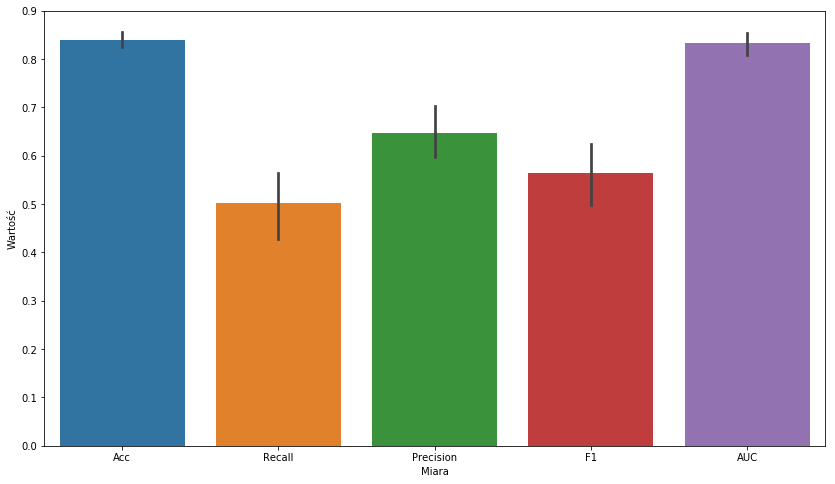

In [32]:
plt.figure(figsize=(14,8))
sns.barplot(x='miara', y='score', data=data_score)
plt.xlabel('Miara')
plt.ylabel('Wartość')
plt.show()

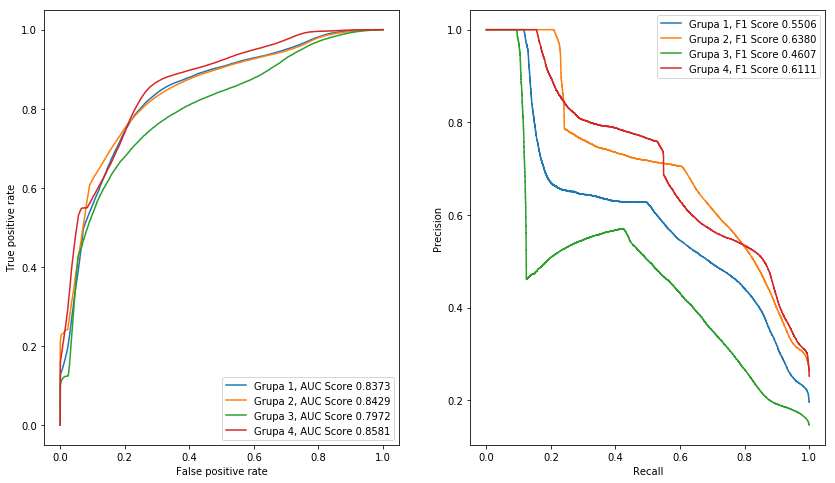

In [41]:
# 22 kolumny bez skalowania
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))
#sns.set_style('whitegrid')
ax1.plot(fpr[0], tpr[0], label='Grupa 1, AUC Score {}'.format("%.4f" % scores['AUC'][0]))
ax1.plot(fpr[1], tpr[1], label='Grupa 2, AUC Score {}'.format("%.4f" % scores['AUC'][1]))
ax1.plot(fpr[2], tpr[2], label='Grupa 3, AUC Score {}'.format("%.4f" % scores['AUC'][2]))
ax1.plot(fpr[3], tpr[3], label='Grupa 4, AUC Score {}'.format("%.4f" % scores['AUC'][3]))
ax1.set_ylabel('True positive rate')
ax1.set_xlabel('False positive rate')
ax1.legend()
ax2.plot(re[0], pr[0], label='Grupa 1, F1 Score {}'.format("%.4f" % scores['F1'][0]))
ax2.plot(re[1], pr[1], label='Grupa 2, F1 Score {}'.format("%.4f" % scores['F1'][1]))
ax2.plot(re[2], pr[2], label='Grupa 3, F1 Score {}'.format("%.4f" % scores['F1'][2]))
ax2.plot(re[3], pr[3], label='Grupa 4, F1 Score {}'.format("%.4f" % scores['F1'][3]))
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
ax2.legend()
plt.show()

# OLS

Liczba obserwacji treningowych: 858605
Liczba obserwacji testowych: 275778
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.805238
1    0.194762
Name: DELAYED, dtype: float64
Accuracy:  0.8579
Recall:  0.4774
Precision:  0.7034
F1 Score:  0.5688
ROC AUC Score: 0.9065
(20,)
Liczba obserwacji treningowych: 1000573
Liczba obserwacji testowych: 291837
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.78026
1    0.21974
Name: DELAYED, dtype: float64
Accuracy:  0.8409
Recall:  0.5919
Precision:  0.7521
F1 Score:  0.6625
ROC AUC Score: 0.9017
(20,)
Liczba obserwacji treningowych: 1036178
Liczba obserwacji testowych: 292976
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.765763
1    0.234237
Name: DELAYED, dtype: float64
Accuracy:  0.8869
Recall:  0.4106
Precision:  0.6914
F1 Score:  0.5152
ROC AUC Score: 0.9183
(20,)
Liczba obserwacji treningowych: 947697
Liczba obserwacji testowych: 286368
Liczba kolumn: 20
Rozkład zmiennej endogenicznej:

0    0.849825
1    0.1501

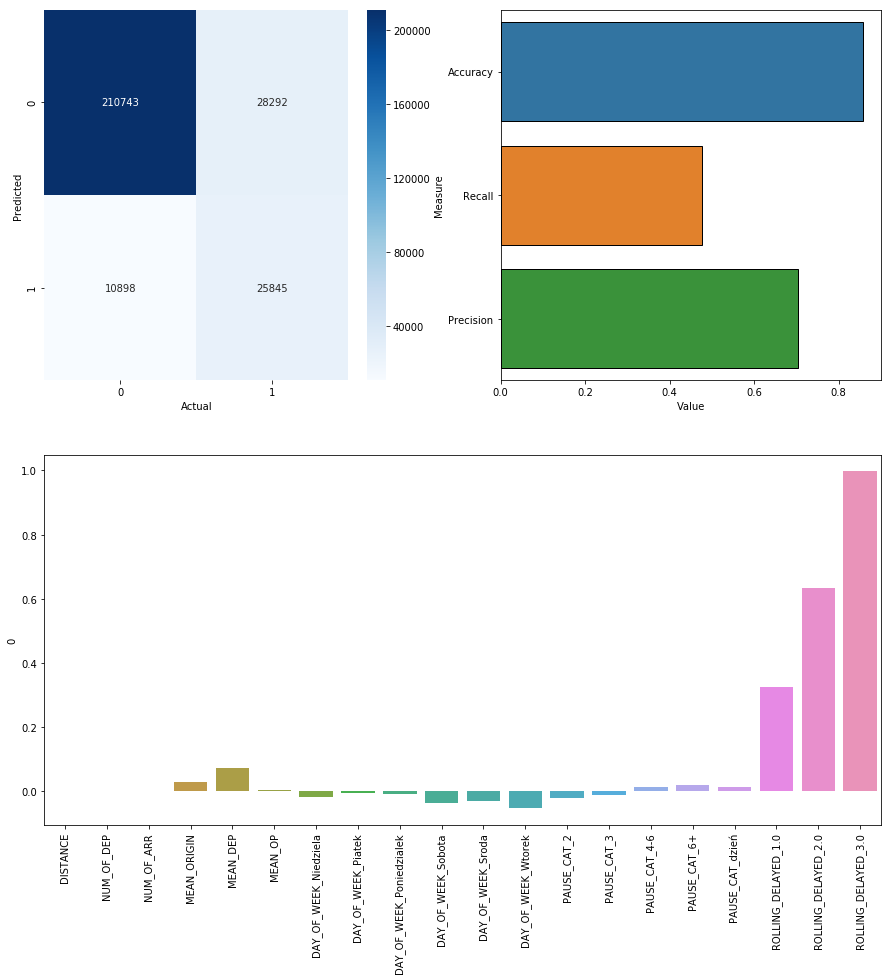

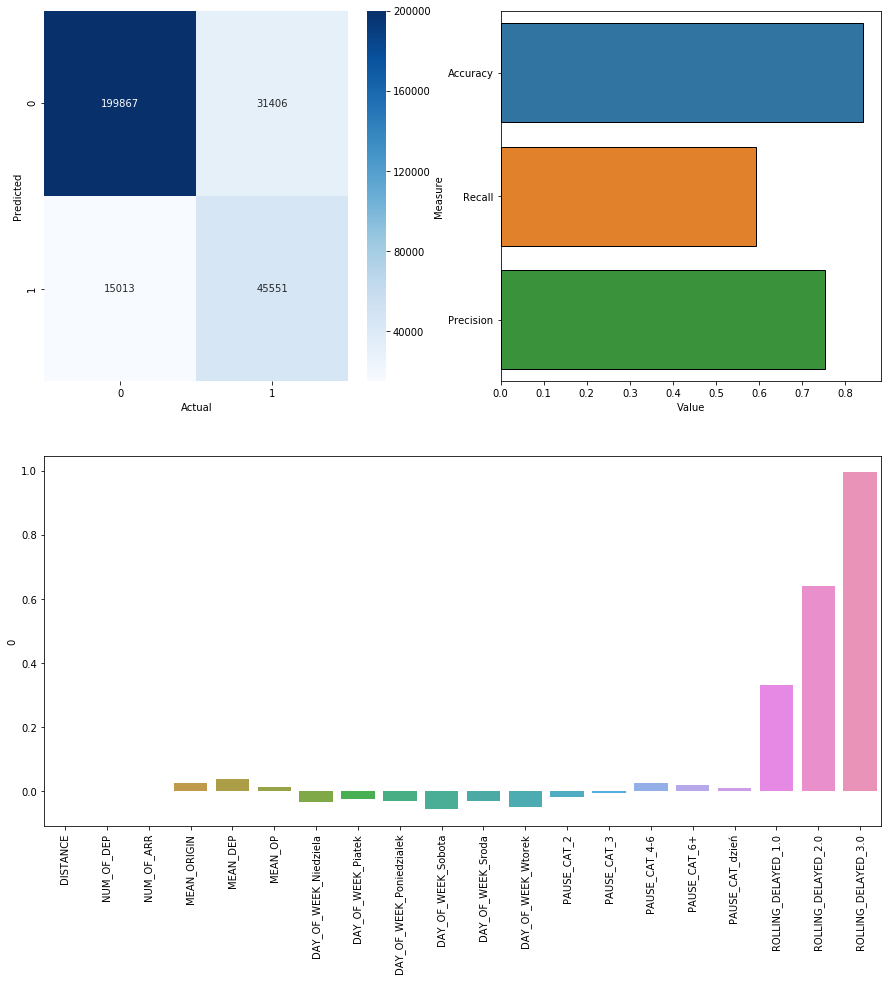

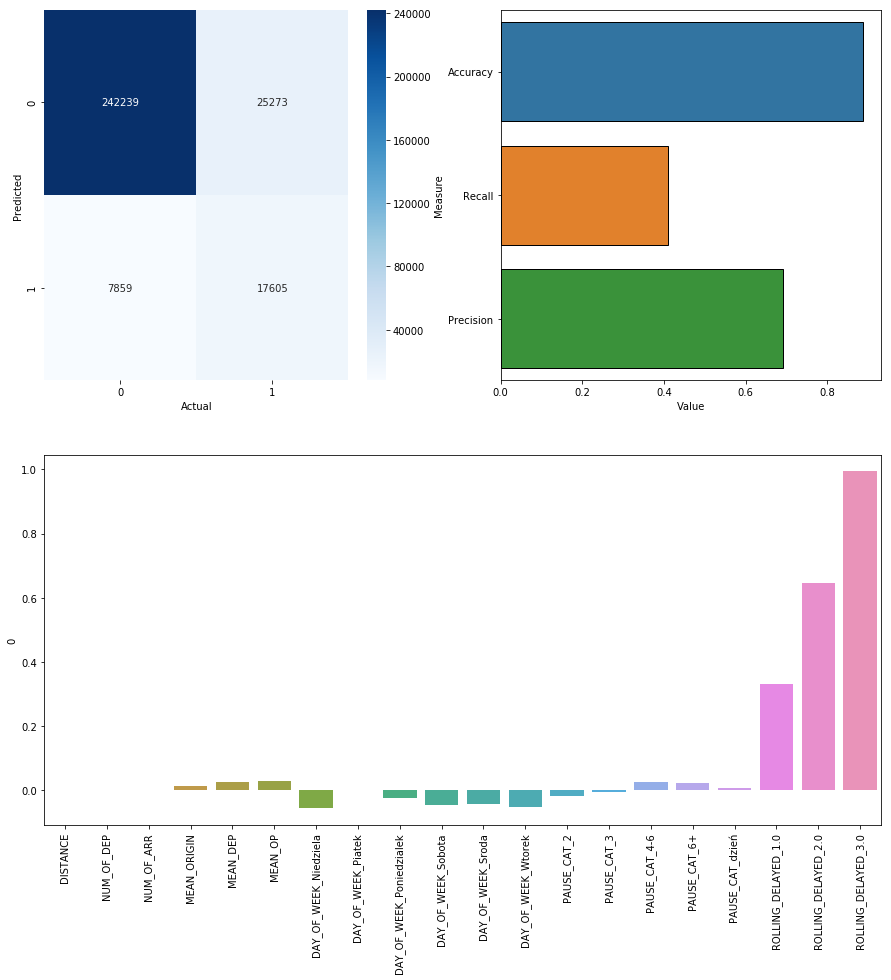

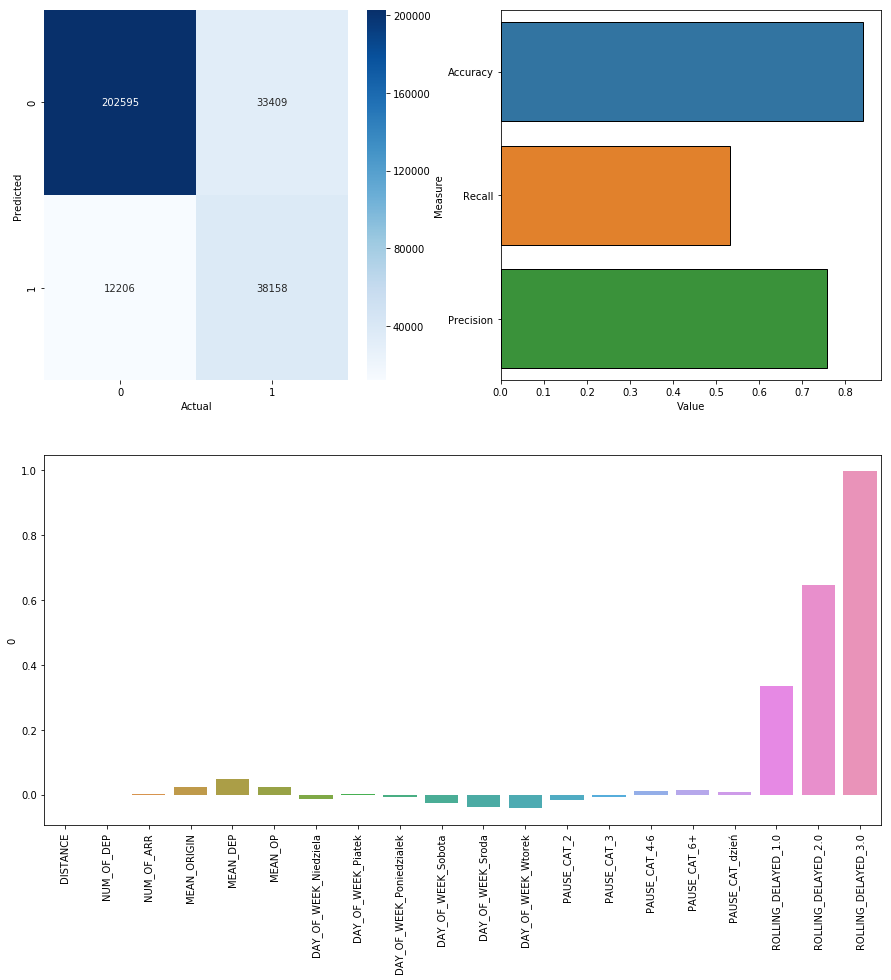

In [38]:
#nowe
group_train = [train1new,train2new,train3new,train4new]
group_test = [test1new,test2new,test3new,test4new]
index = [0,1,2,3]
scores = pd.DataFrame(columns=['Acc', 'Recall', 'Precision', 'F1', 'AUC'], index=index, dtype=np.float)
data_score = pd.DataFrame(columns=['miara', 'score', 'cut_off'])
data_coef = pd.DataFrame()
data_histogram = pd.DataFrame(columns=[1, 2, 3, 4])
fpr = []
tpr = []
thresh = []
pr = []
re = []
threshhh = []

columns_to_use = ['DAY_OF_WEEK', 'ORIGIN', 'OP_UNIQUE_CARRIER', 'DISTANCE',
                  'CRS_DEP_TIME_CAT', 'NUM_OF_DEP', 'NUM_OF_ARR', 'PAUSE_CAT',
                  'ROLLING_DELAYED', 'DELAYED']
#columns_to_use = ['ORIGIN', 'OP_UNIQUE_CARRIER', 'PAUSE_CAT', 'ROLLING_DELAYED', 'DELAYED']

for i, (train, test) in zip(index, zip(group_train, group_test)):
    x_train, x_test, y_train, y_test = train_test(train, test, get_dummies=True, scale=False)
    model, acc, rec, prec, auc, f1, f, t, th, p, r, thresholds, probality, coef = model_perfomance_ols(ols, x_train, y_train, x_test, y_test, coef=True)
    scores.loc[i]['Acc'] = acc
    scores.loc[i]['Recall'] = rec
    scores.loc[i]['Precision'] = prec
    scores.loc[i]['F1'] = f1
    scores.loc[i]['AUC'] = auc
    data_histogram.iloc[:,i] = pd.Series(probality)
    data_concat = pd.DataFrame({'miara': ['Acc', 'Recall', 'Precision', 'F1', 'AUC'],
                              'score': [acc, rec, prec, f1, auc],
                              'cut_off': i})
    data_score = pd.concat([data_score, data_concat], ignore_index=True)
    #data_c = pd.DataFrame({'coef': [x for x in x_train.columns.values],
                           #'score': coef.T.values,
                           #'grupa': i})
    data_c = coef.T.reset_index()
    data_coef = pd.concat([data_coef, data_c], ignore_index=True)

    fpr.append(f)
    tpr.append(t)
    thresh.append(th)
    pr.append(p)
    re.append(r)
    threshhh.append(thresholds)

In [16]:
data_score

,miara,score,cut_off
0,Acc,0.857893,0
1,Recall,0.477400,0
2,Precision,0.703399,0
3,F1,0.568772,0
4,AUC,0.906473,0
5,Acc,0.840942,1
6,Recall,0.591902,1
7,Precision,0.752113,1
8,F1,0.662459,1
9,AUC,0.901686,1


C:\Data science\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


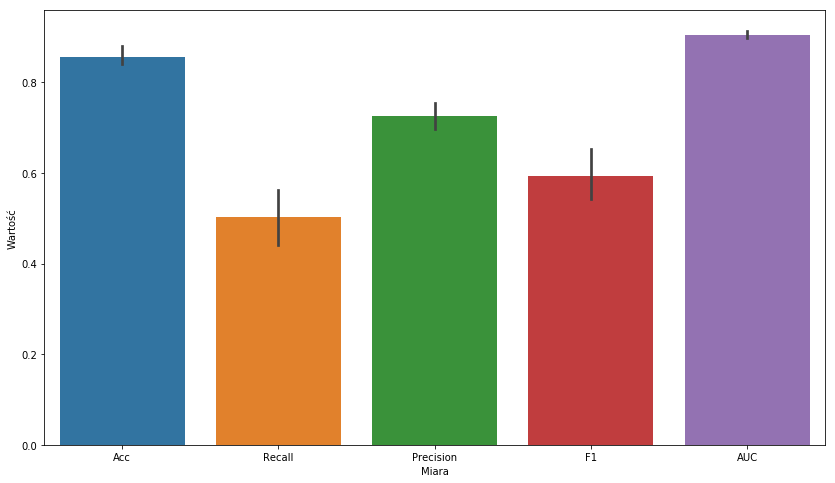

In [35]:
plt.figure(figsize=(14,8))
sns.barplot(x='miara', y='score', data=data_score)
plt.xlabel('Miara')
plt.ylabel('Wartość')
plt.show()

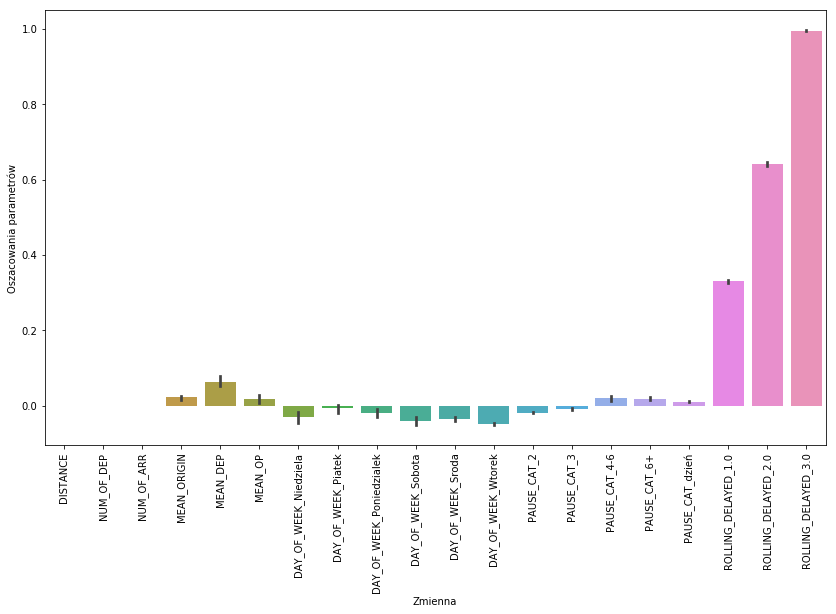

In [36]:
plt.figure(figsize=(14,8))
sns.barplot(x='index', y=0, data=data_coef)
plt.xticks(rotation=90)
plt.xlabel('Zmienna')
plt.ylabel('Oszacowania parametrów')
plt.show()

In [14]:
data_coef.to_excel('ols.xlsx')

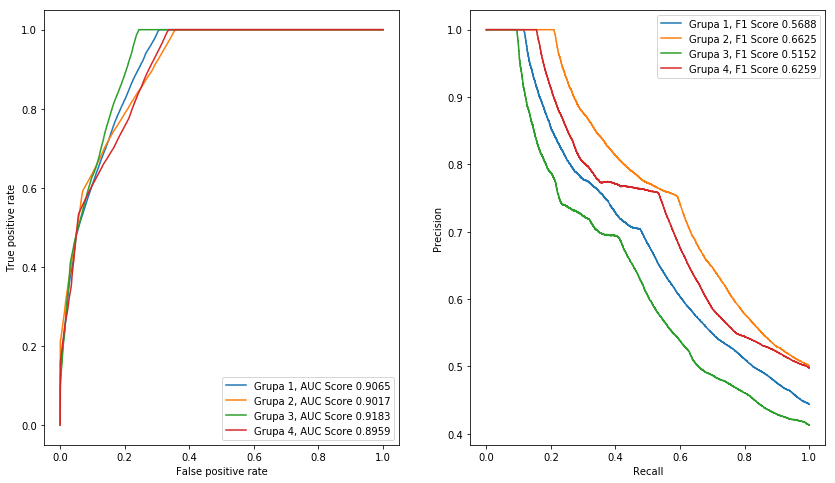

In [39]:
# 22 kolumny bez skalowania
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,8))
#sns.set_style('whitegrid')
ax1.plot(fpr[0], tpr[0], label='Grupa 1, AUC Score {}'.format("%.4f" % scores['AUC'][0]))
ax1.plot(fpr[1], tpr[1], label='Grupa 2, AUC Score {}'.format("%.4f" % scores['AUC'][1]))
ax1.plot(fpr[2], tpr[2], label='Grupa 3, AUC Score {}'.format("%.4f" % scores['AUC'][2]))
ax1.plot(fpr[3], tpr[3], label='Grupa 4, AUC Score {}'.format("%.4f" % scores['AUC'][3]))
ax1.set_ylabel('True positive rate')
ax1.set_xlabel('False positive rate')
ax1.legend()
ax2.plot(re[0], pr[0], label='Grupa 1, F1 Score {}'.format("%.4f" % scores['F1'][0]))
ax2.plot(re[1], pr[1], label='Grupa 2, F1 Score {}'.format("%.4f" % scores['F1'][1]))
ax2.plot(re[2], pr[2], label='Grupa 3, F1 Score {}'.format("%.4f" % scores['F1'][2]))
ax2.plot(re[3], pr[3], label='Grupa 4, F1 Score {}'.format("%.4f" % scores['F1'][3]))
ax2.set_ylabel('Precision')
ax2.set_xlabel('Recall')
ax2.legend()
plt.show()

# Results graph

In [33]:
wyk = pd.read_excel('ols.xlsx')
wyk = wyk[wyk['miara'] != 'AUC']
mapping = {'logit': 'Logit',
          'ols': 'LMP',
          'nb': 'NB'}
wyk['model'] = wyk['model'].map(mapping)

In [34]:

wyk.head(5)

,id,miara,wynik,kwartal,model
0,0,Acc,0.857737,0,Logit
1,1,Recall,0.474260,0,Logit
2,2,Precision,0.704467,0,Logit
3,3,F1,0.566883,0,Logit
5,5,Acc,0.840942,1,Logit


Text(0.5, 0, 'Miara')

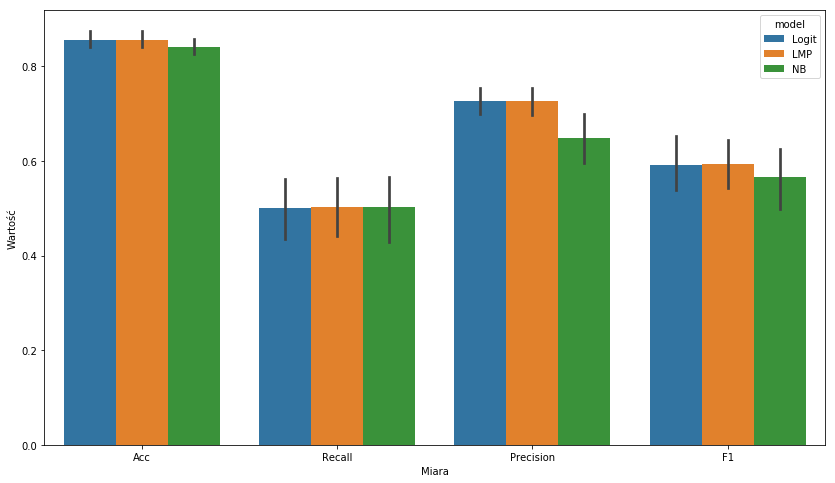

In [35]:
plt.figure(figsize=(14,8))
sns.barplot(x='miara', y='wynik', hue='model', data=wyk)
plt.ylabel('Wartość')
plt.xlabel('Miara')

# ANOVA

In [11]:
anova_df = df.copy()
anova_df = anova_df[['OP_UNIQUE_CARRIER', 'DEP_DELAY']]
anova_df['DEP_DELAY'] = np.where(anova_df['DEP_DELAY'] < 0, 0, anova_df['DEP_DELAY'])
const = np.ones(anova_df.shape[0])
anova_df['const'] = const
anova_x = pd.get_dummies(anova_df.drop(columns='DEP_DELAY'), drop_first=True)
anova_y = anova_df['DEP_DELAY']

In [12]:
anova_df.head(5)

,OP_UNIQUE_CARRIER,DEP_DELAY,const
0,AA,0.0,1.0
1,UA,0.0,1.0
2,AS,17.0,1.0
3,VX,0.0,1.0
4,VX,16.0,1.0


In [13]:
import statsmodels.api as sm

from statsmodels.formula.api import ols

model = ols('DEP_DELAY ~ C(OP_UNIQUE_CARRIER)', data=anova_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              DEP_DELAY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1875.
Date:                Thu, 26 Sep 2019   Prob (F-statistic):               0.00
Time:                        20:14:35   Log-Likelihood:            -2.5534e+07
No. Observations:             4990099   AIC:                         5.107e+07
Df Residuals:                 4990087   BIC:                         5.107e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [14]:
aov_table = sm.stats.anova_lm(model, typ=2)
print (aov_table)

                            sum_sq         df            F  PR(>F)
C(OP_UNIQUE_CARRIER)  3.361078e+07       11.0  1875.312585     0.0
Residual              8.130558e+09  4990087.0          NaN     NaN
